## Compare all tflite 

All tflite models are compared against each other.

As can be seen, the quantized model often loses accuracy.

ana0910s1 - models are not trained on the relabeled data. So the accuracy is much less against the other models.


In [64]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana_i32s100_dropout"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100
input_shape = (32,32,3)

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [65]:
"""calculate flops of tflite model. only conv and depthwise_conv considered
based on https://github.com/lisosia/tflite-flops/blob/main/tflite_flops/calc.py
"""

import sys
import tflite

def calc_flops(path):
    with open(path, 'rb') as f:
        buf = f.read()
        model = tflite.Model.GetRootAsModel(buf, 0)

    graph = model.Subgraphs(0)

    # help(tflite.BuiltinOperator)
    # ABS = 101
    # CONV_2D = 3
    # CUMSUM = 128

    total_flops = 0.0
    for i in range(graph.OperatorsLength()):
        op = graph.Operators(i)
        op_code = model.OperatorCodes(op.OpcodeIndex())
        op_code_builtin = op_code.BuiltinCode()

        op_opt = op.BuiltinOptions()

        flops = 0.0
        if op_code_builtin == tflite.BuiltinOperator.CONV_2D:
            # input shapes: in, weight, bias
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            bias_shape = graph.Tensors( op.Inputs(2) ).ShapeAsNumpy()
            # output shape
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # ops options
            opt = tflite.Conv2DOptions()
            opt.Init(op_opt.Bytes, op_opt.Pos)
            # opt.StrideH()

            # flops. 2x means mul(1)+add(1). 2x not needed if you calculate MACCs
            # refer to https://github.com/AlexeyAB/darknet/src/convolutional_layer.c `l.blopfs =`
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
    
        elif op_code_builtin == tflite.BuiltinOperator.DEPTHWISE_CONV_2D:
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # flops
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
    
        total_flops += flops
    return total_flops

In [66]:
Input_dir='data_resize_all'

files = glob.glob("data_raw_all" + '/*.jpg')
y_data = np.empty((len(files)))
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),input_shape[0],input_shape[1],input_shape[2]))

for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile).resize((input_shape[0],input_shape[1]), Image.Resampling.NEAREST)
    test_image = np.array(test_image, dtype="float32")
    f_data[i] =  aktfile
    x_data[i] = test_image
    y_data[i] =  category
print("Analog data count: ", len(y_data))  

#x_data = np.array(x_data).astype(np.floa<t32)
#y_data = np.array(y_data)
#y_data = np.expand_dims(y_data, -1)#.astype(np.int8)
print(x_data.shape)

x_data, y_data, f_data = shuffle(x_data, y_data, f_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
y_train = keras.utils.to_categorical(y_train*10, 100)
y_test = keras.utils.to_categorical(y_test*10, 100)

print(np.expand_dims(y_data, axis=1).shape)

Analog data count:  6661
(6661, 32, 32, 3)
(6661, 1)


## functions for evaluation

The functions to evaluate the models.

In [67]:
import numpy as np
from tensorflow import keras
import pandas as pd

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1, fontsize=32)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    plt.show()
    return fig

def evaluate_ziffer_tflite(model_path, x_data, y_data, f_data, title, max_delta = 0.11):
    false_images = []
    false_labels = []
    false_predicted = []

    # we use the tflite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    # ignore models with other shape than 32,32,3
    if ((interpreter.get_input_details()[0]["shape"] != (1, 32, 32, 3)).any()):
        return


    for x, y, f in zip(x_data, y_data, f_data):
        
        interpreter.set_tensor(input_index, np.expand_dims(x.astype(np.float32), axis=0))
        # Run inference.
        interpreter.invoke()
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.get_tensor(output_index)
        if (len(output[0])==2):
            out_sin = output[0][0]  
            out_cos = output[0][1]
            prediction = np.round(((np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1)*10,1)
        else:
            prediction = (np.argmax(output, axis=1).reshape(-1)/10)[0]

        difference = min(abs(prediction-y), abs(prediction-(10-y)))
        #print(prediction, y, difference)
        if difference>max_delta:
            false_images.append(x)
            false_labels.append( "Expected: " + str(y) + "\n Predicted: " + str(prediction) + "\n" + str(f)[-28:-5])
            false_predicted.append(difference)
               
    
    total_flops = "{:.1f}  M FLOPS ".format( calc_flops(model_path) / 1e6)
    accuracy = "{:.2f}%".format((1-len(false_labels)/len(y_data))*100)
    title = f"Model: {os.path.basename(model_path)} ( {total_flops}), Tested images: {len(y_data)}. {len(false_labels)} false predicted. Accuracy is: {accuracy}\nDeviation of false predicted"
    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(np.array(false_predicted)*10).astype(int), minlength=51), title, 51)

    # plot the false predicted images
    #plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))


# Evaluate max_delta = 0.1

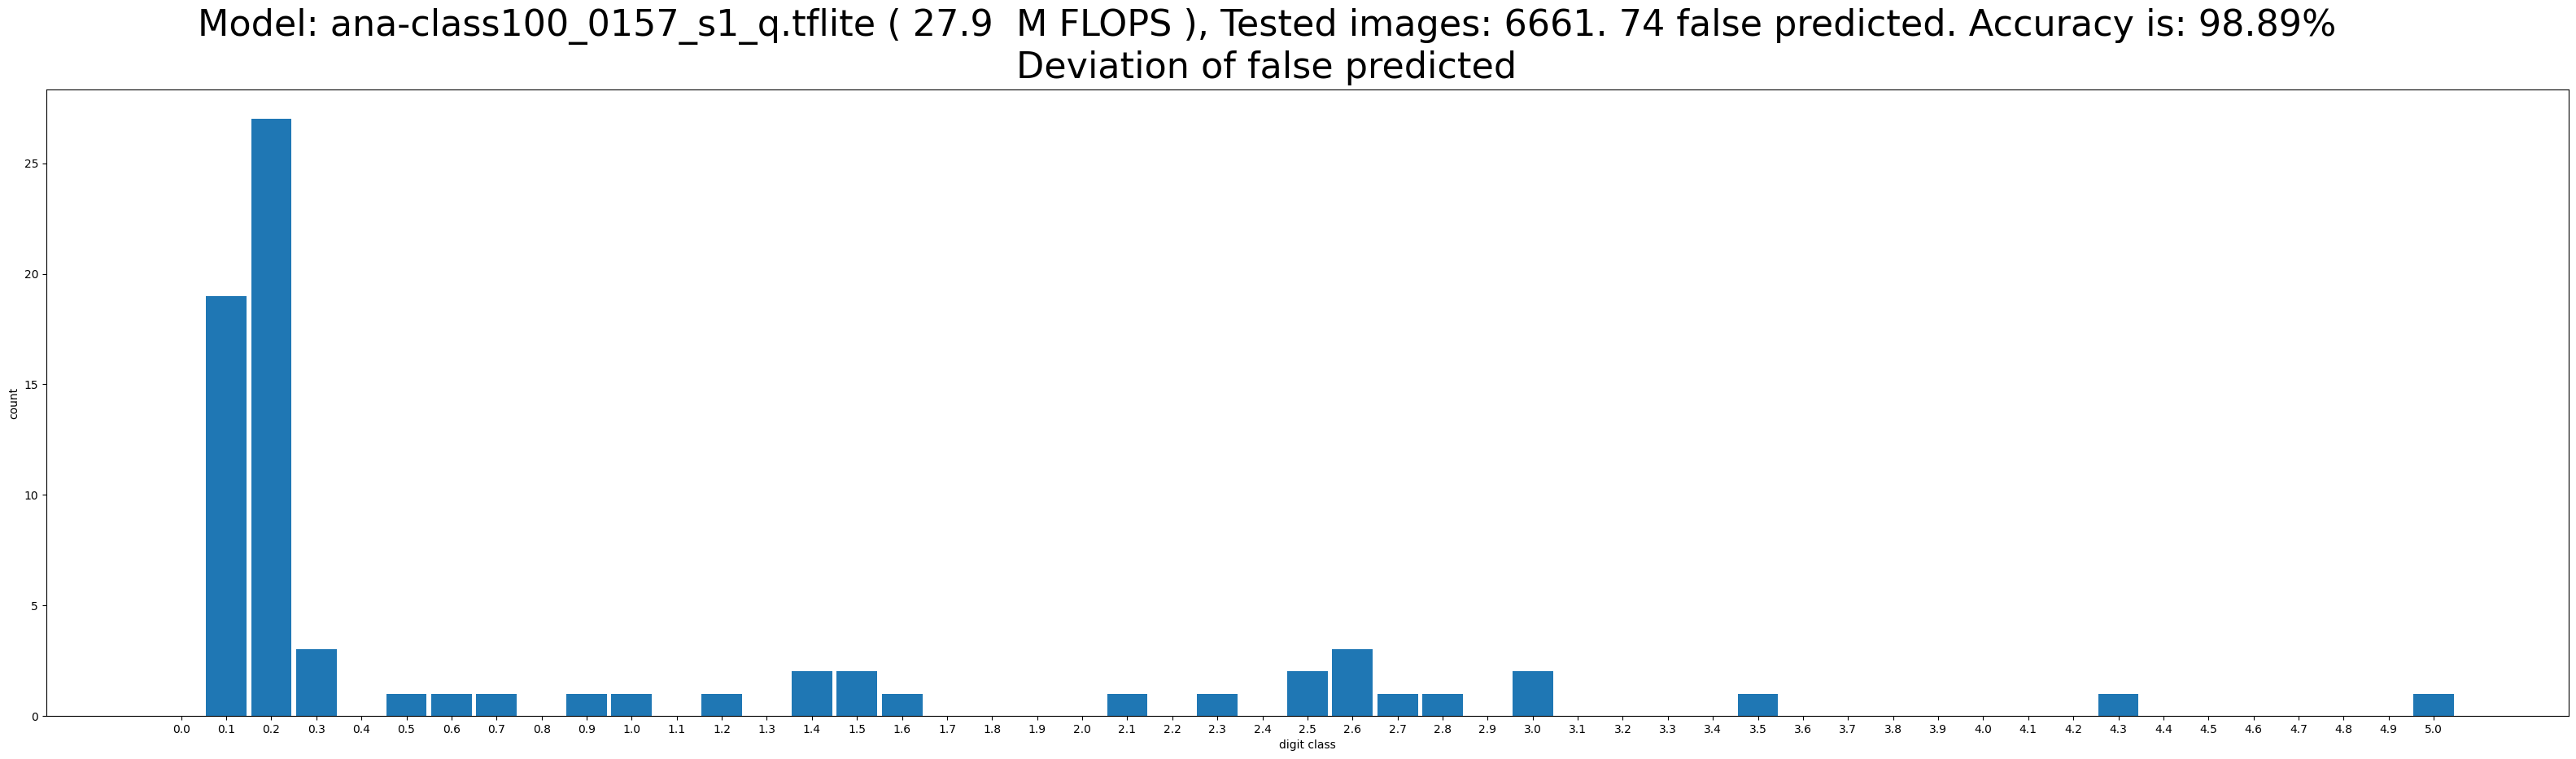

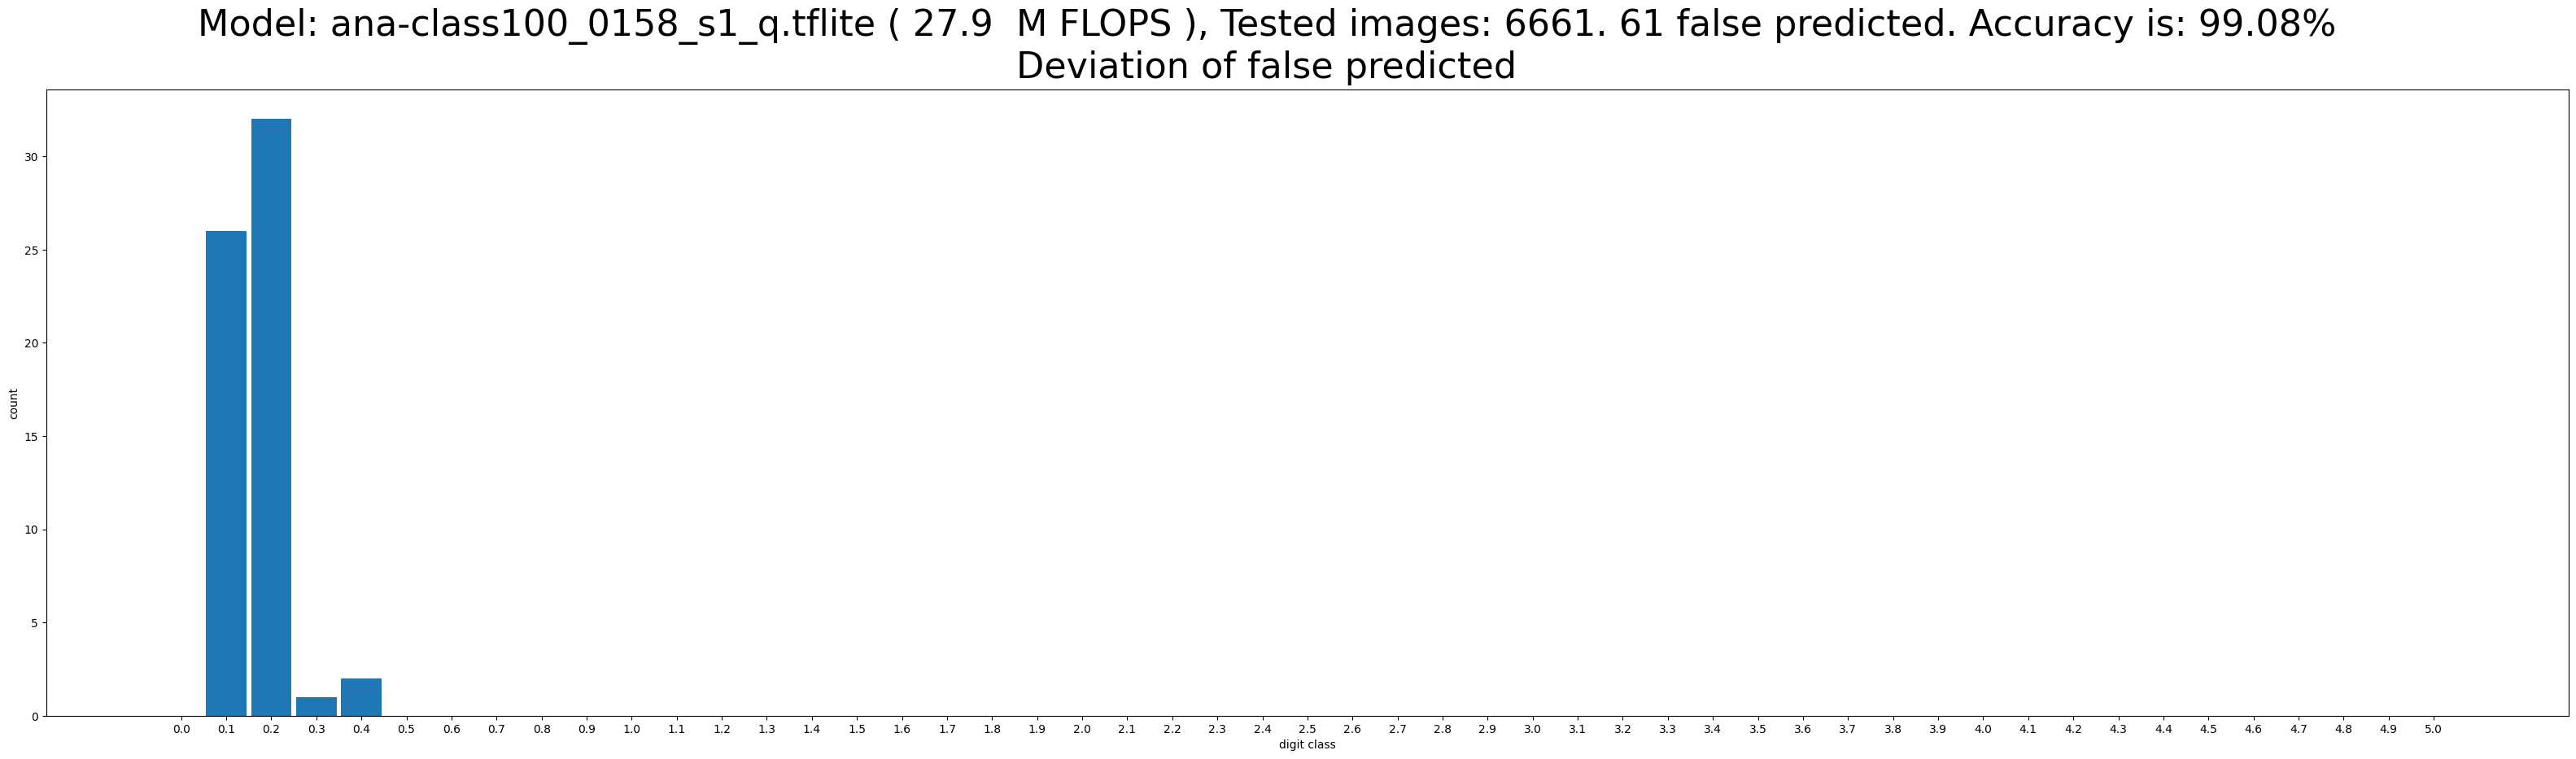

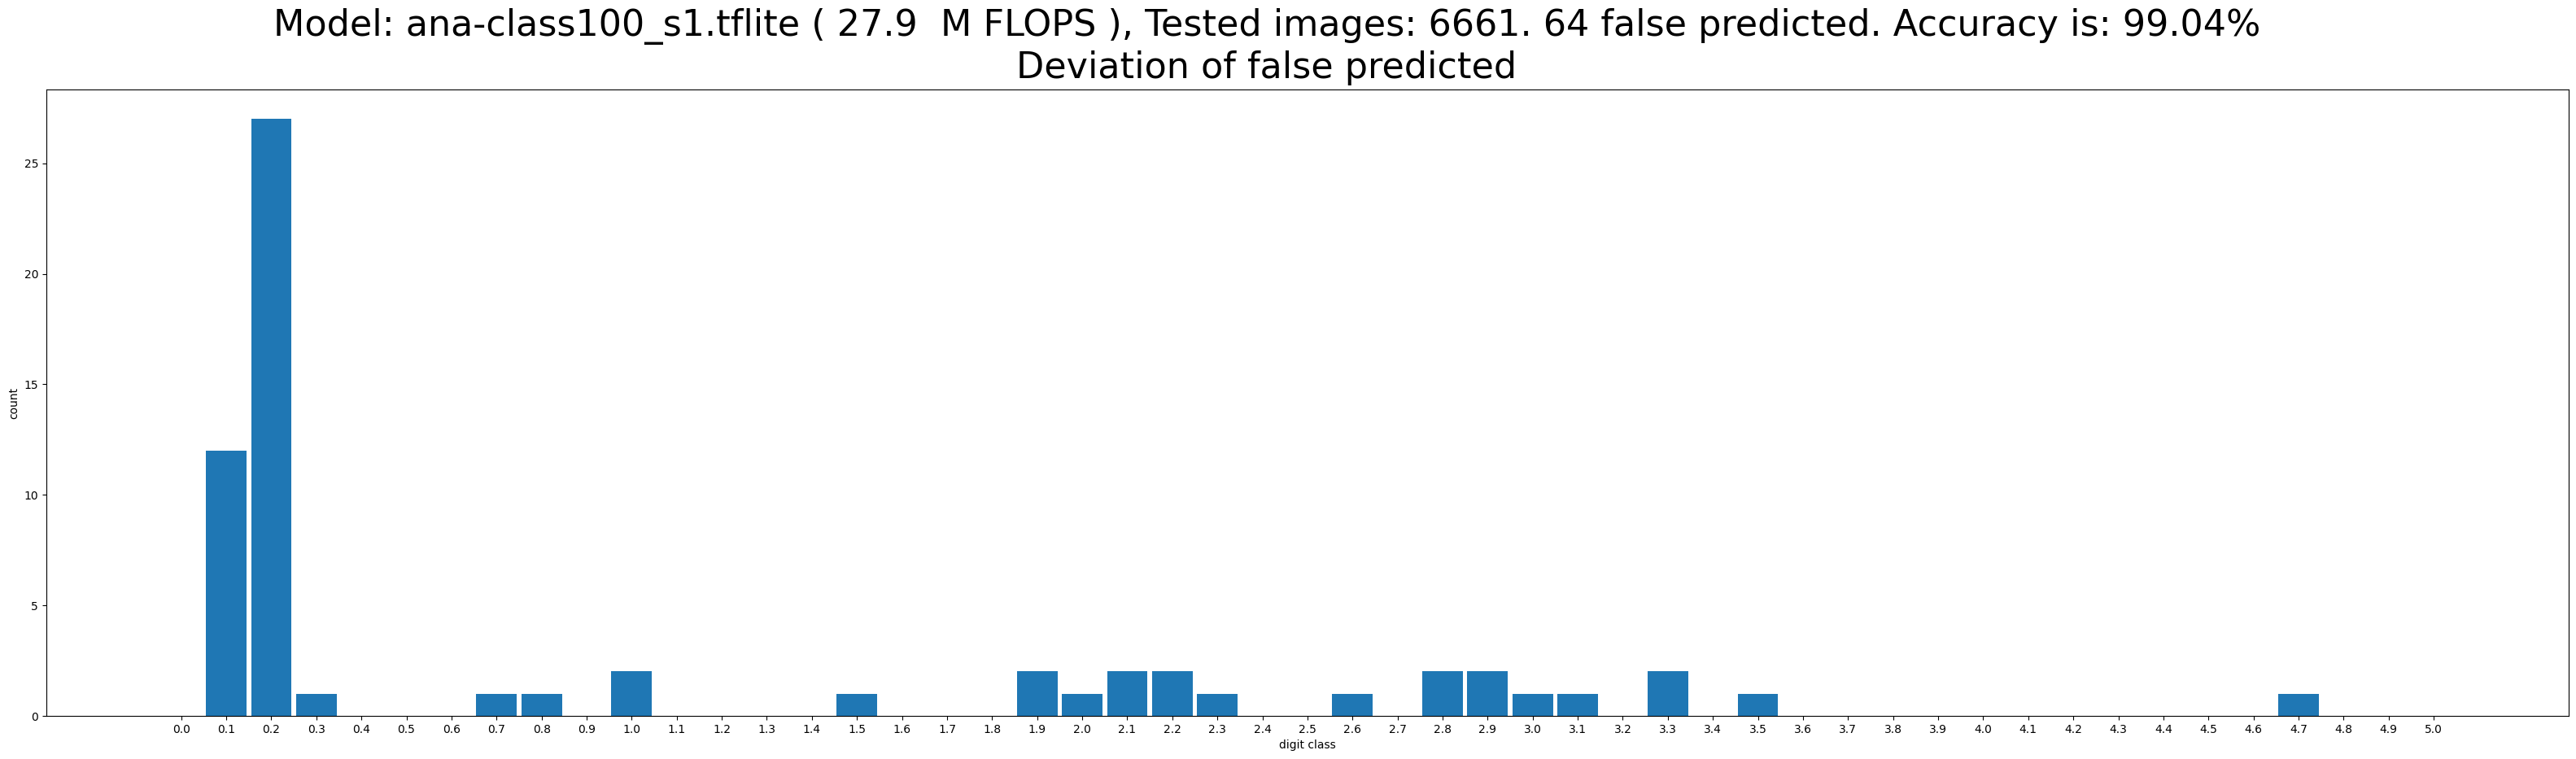

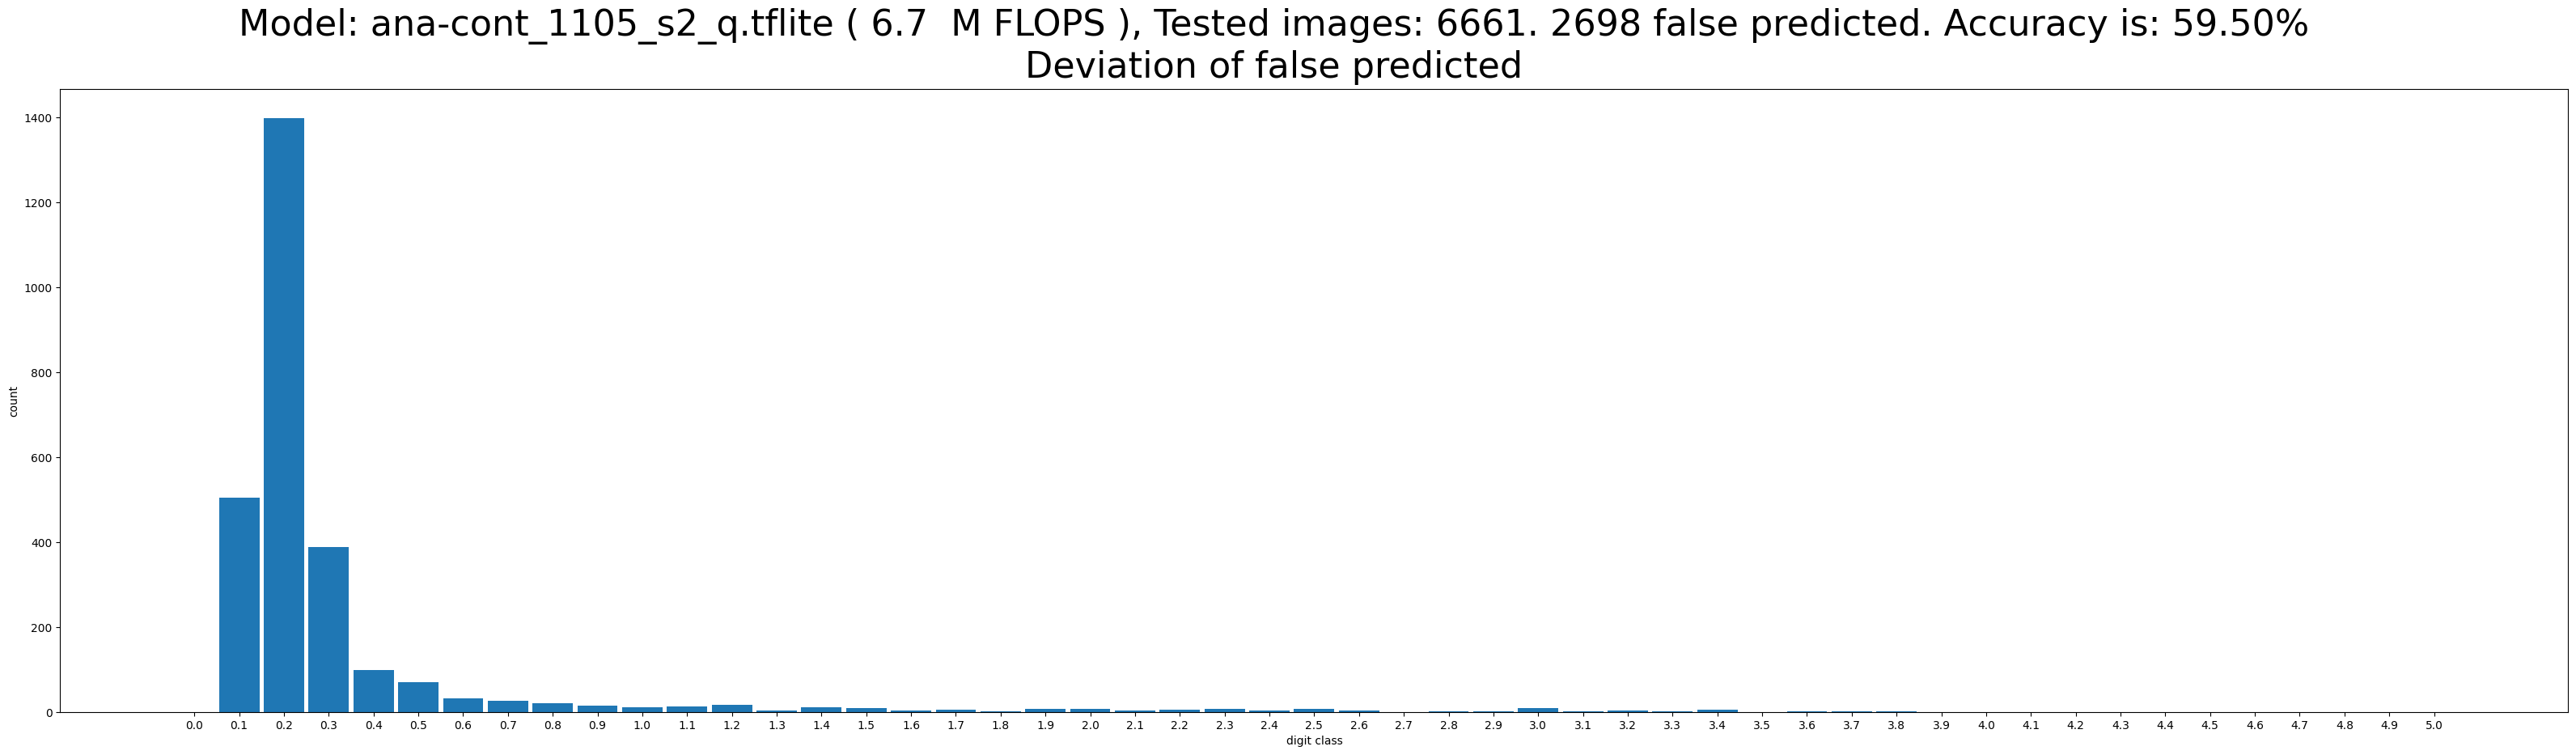

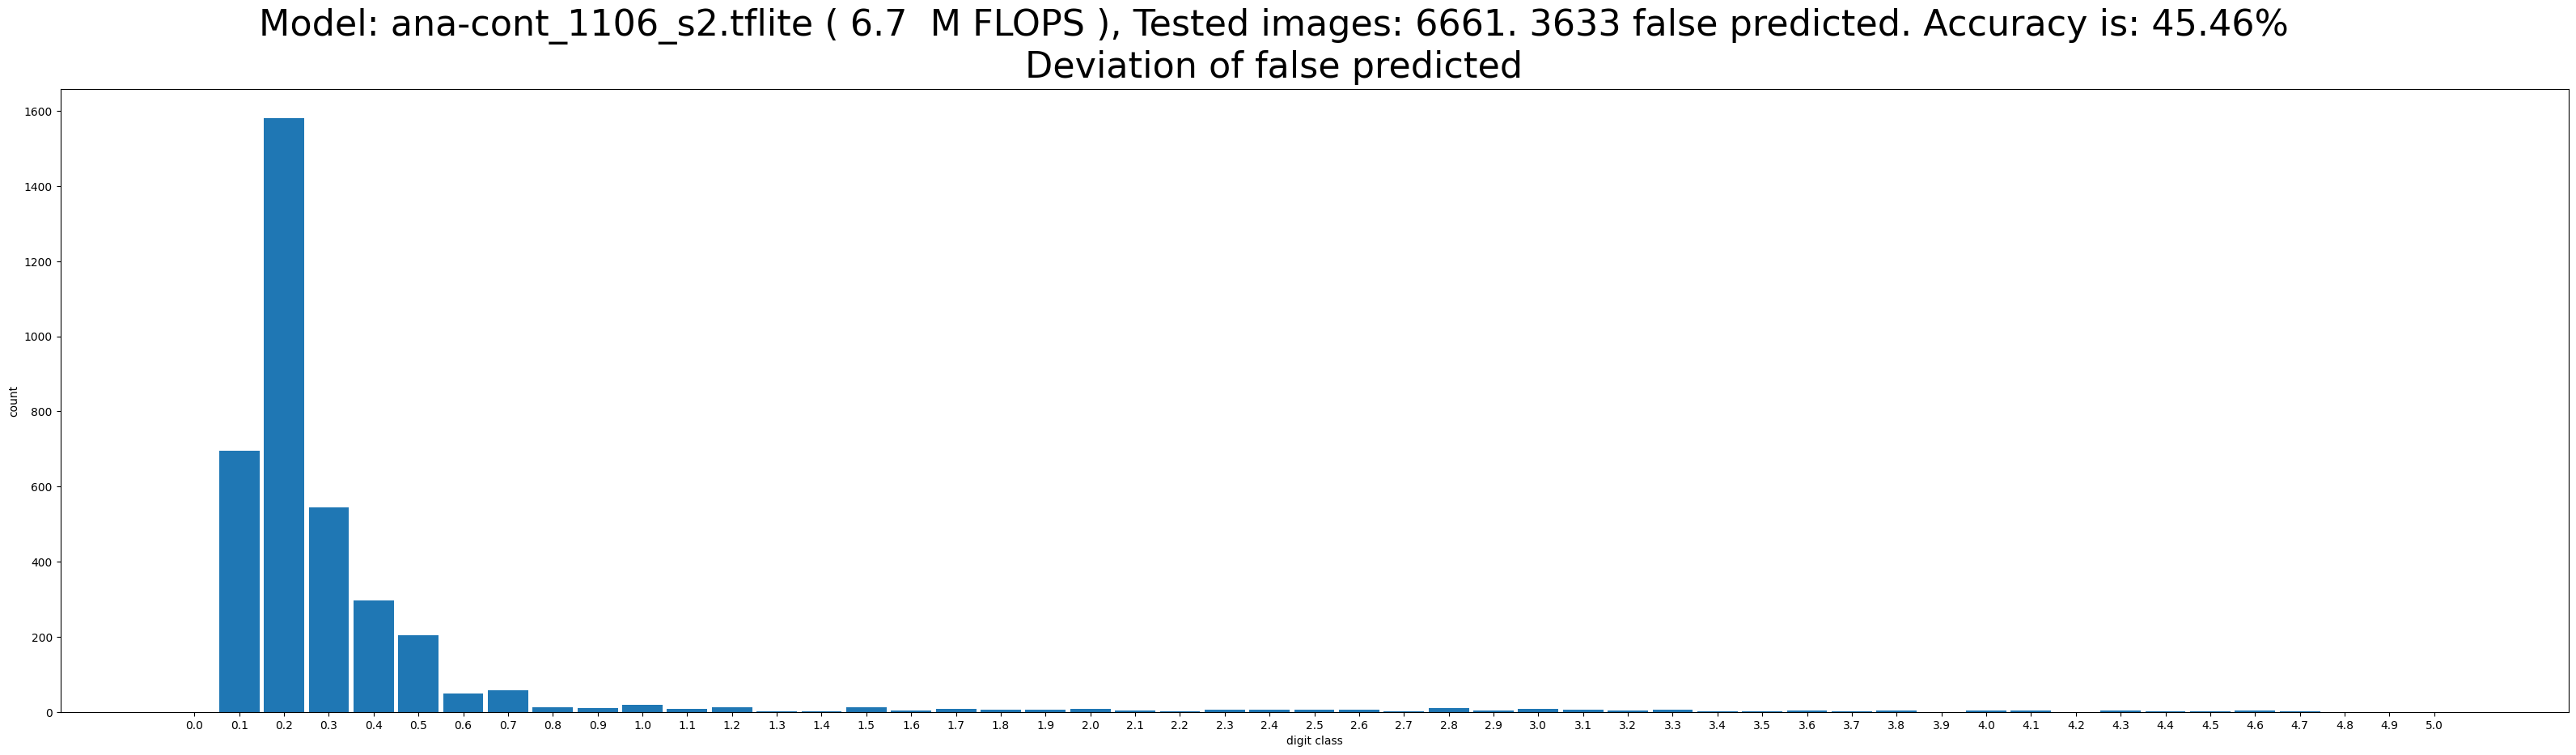

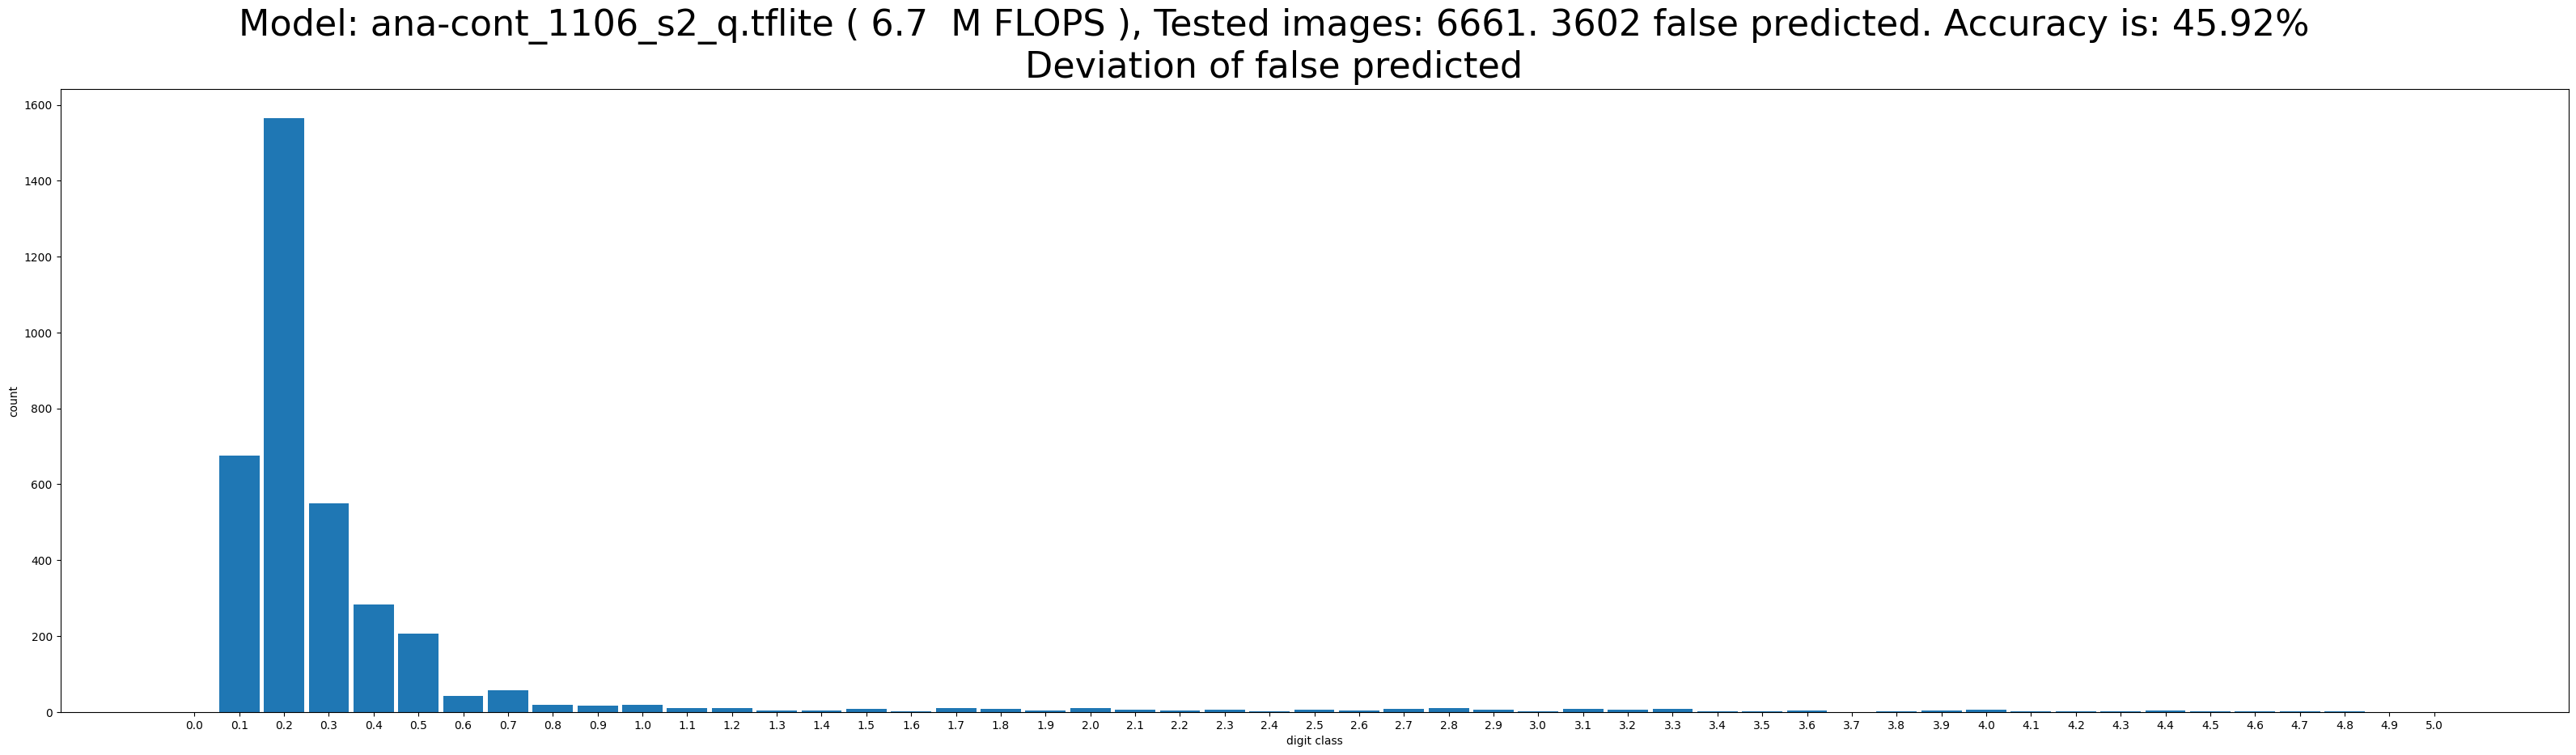

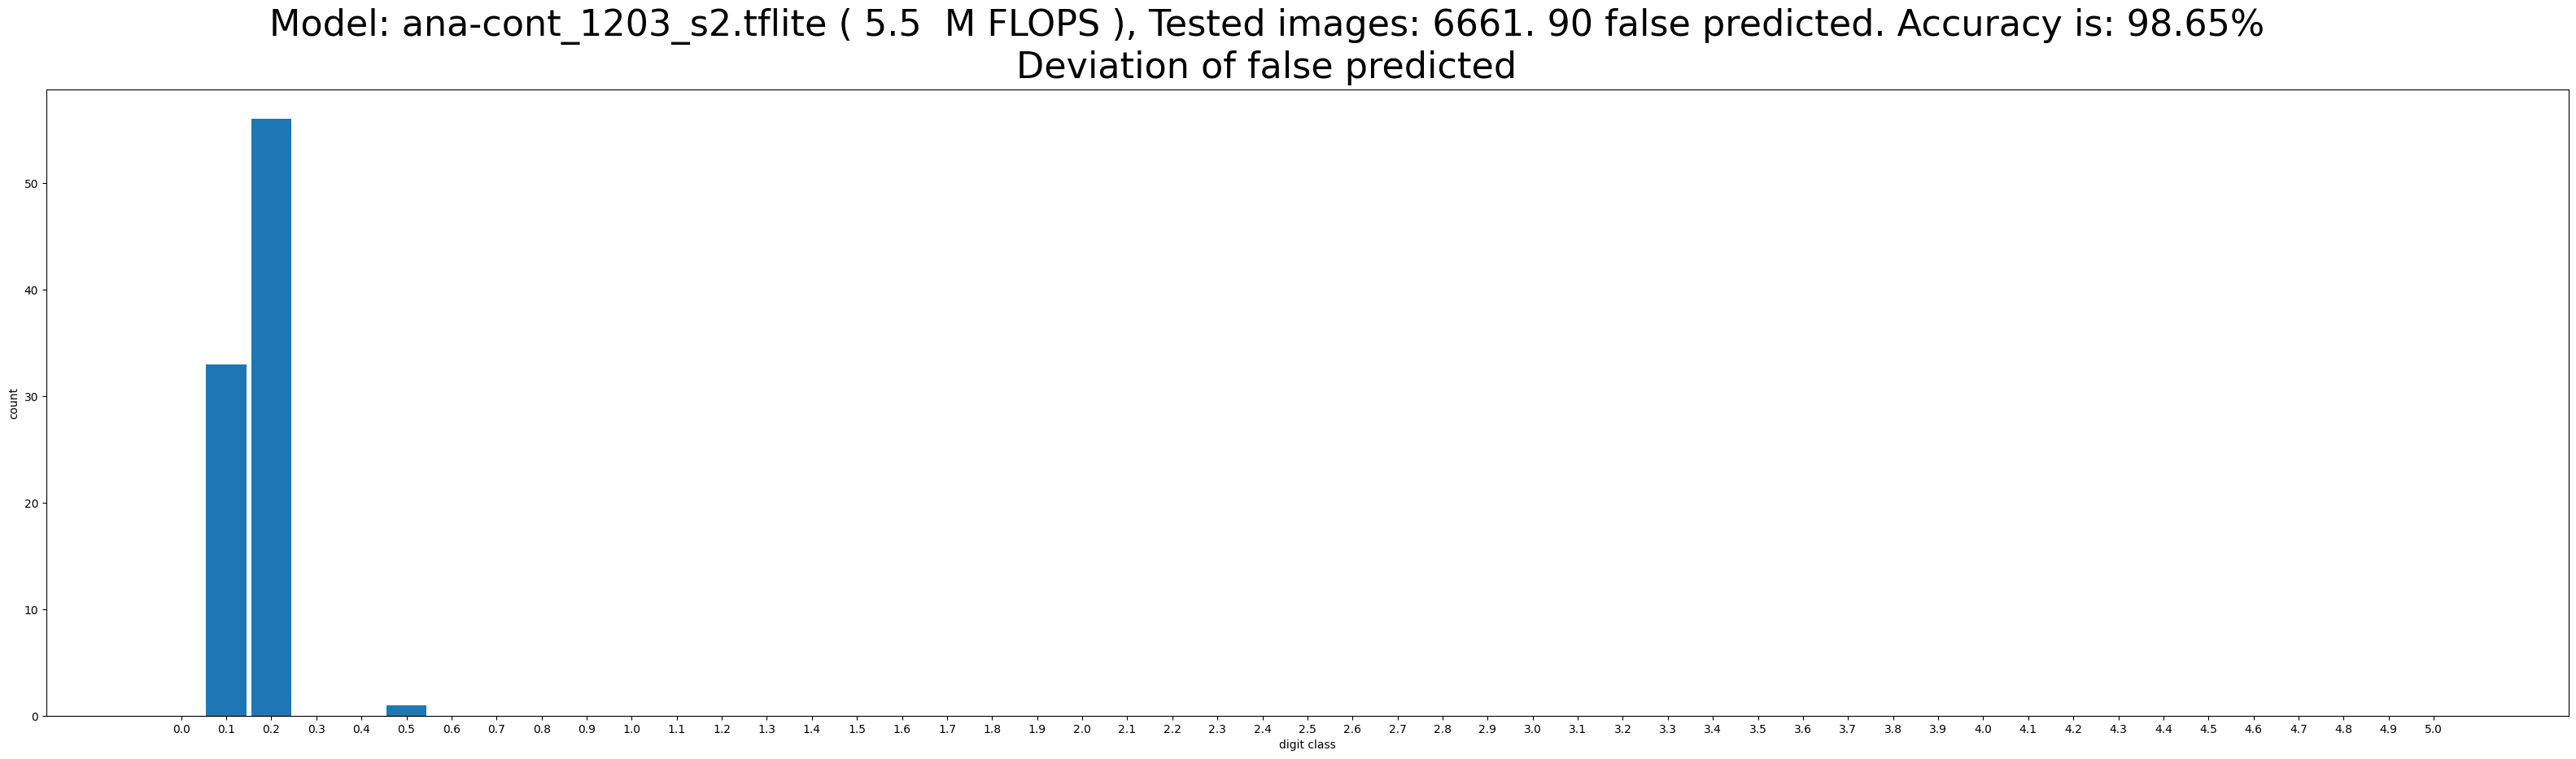

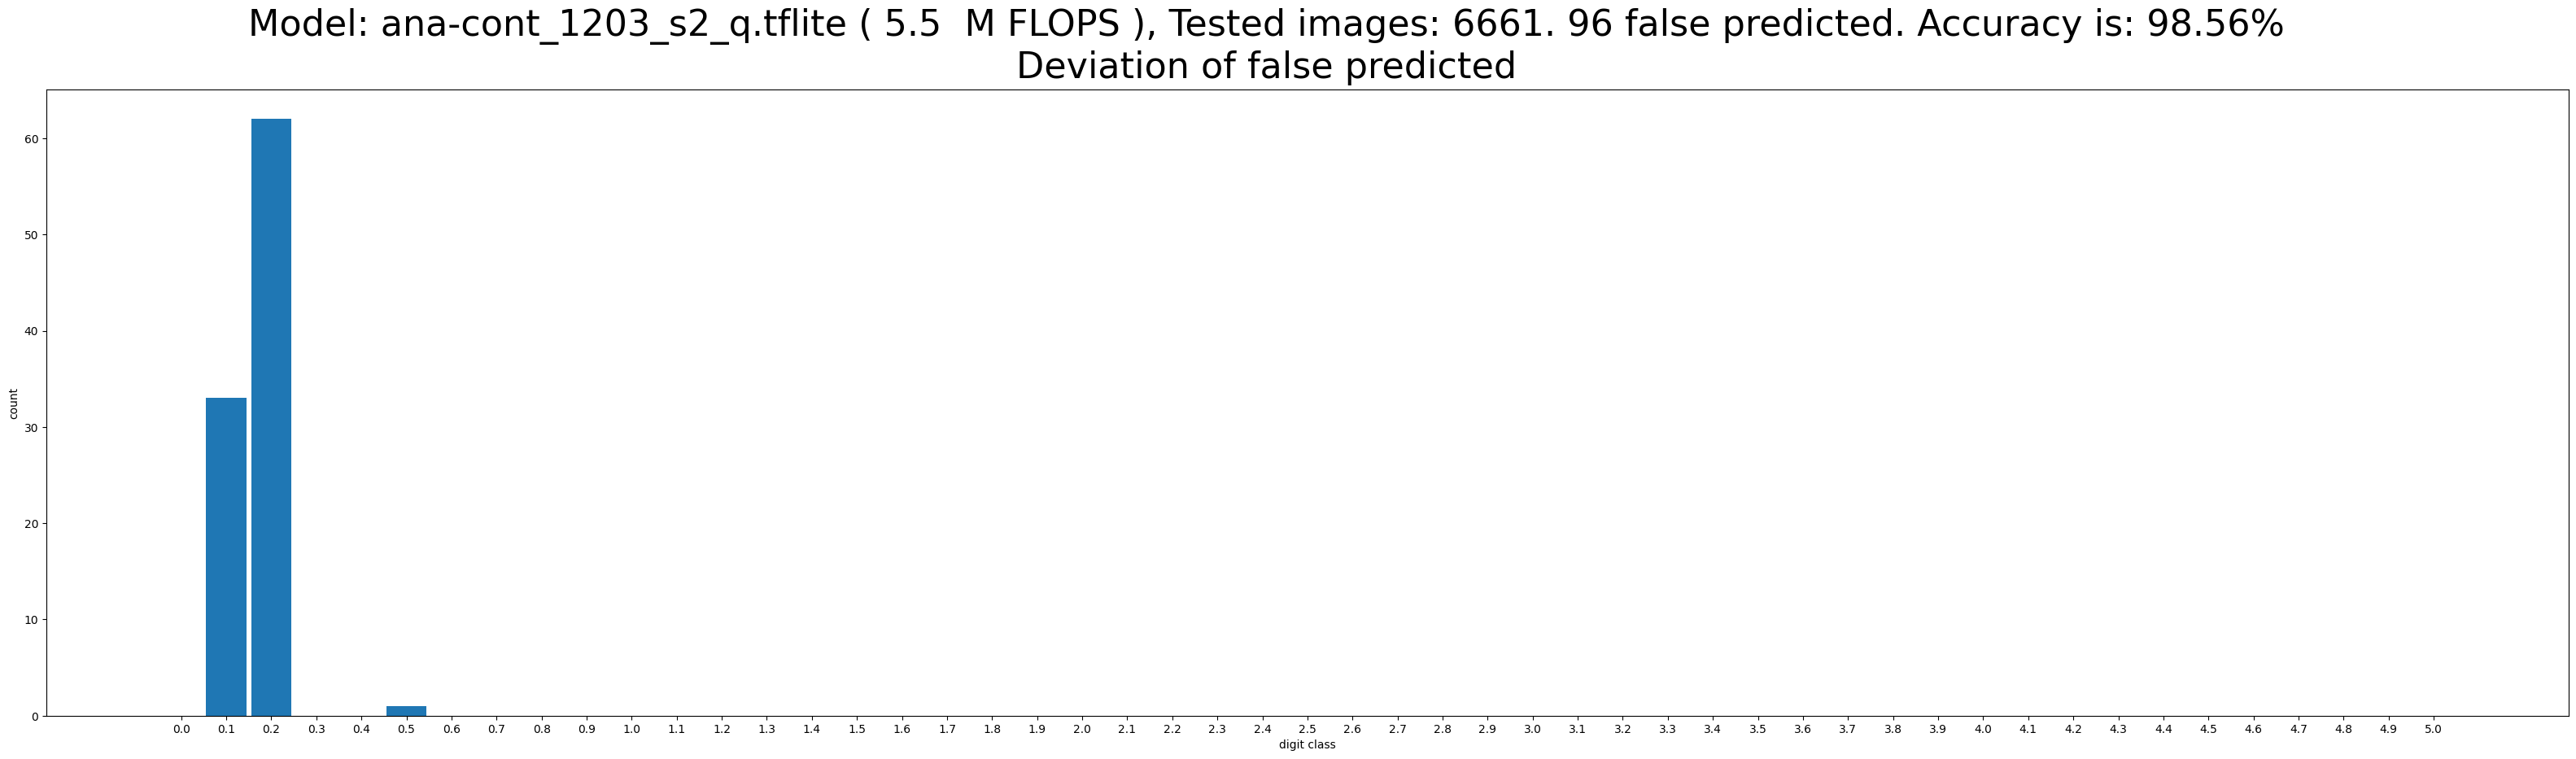

In [68]:
modelfiles = sorted(glob.glob('*.tflite'))
for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, y_data, f_data, title=modelfile, max_delta=0.11)

# Evaluate max_delta = 0.0

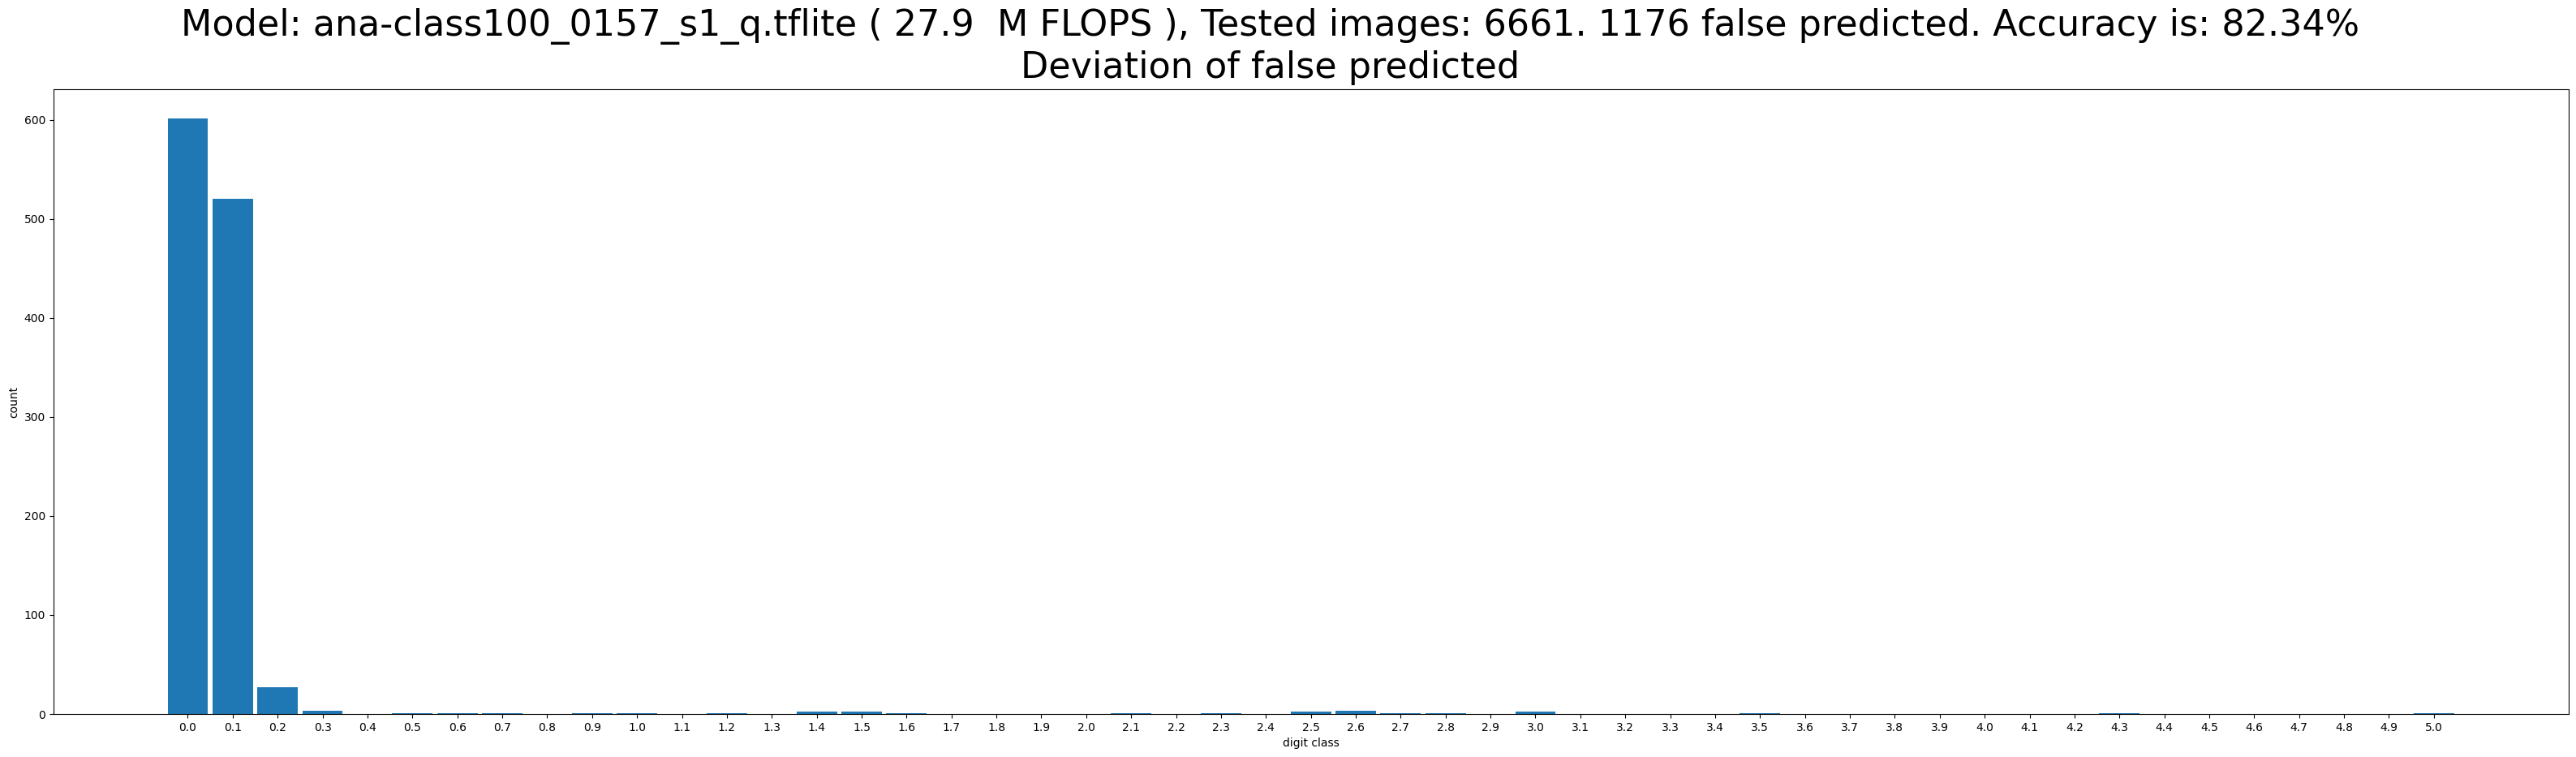

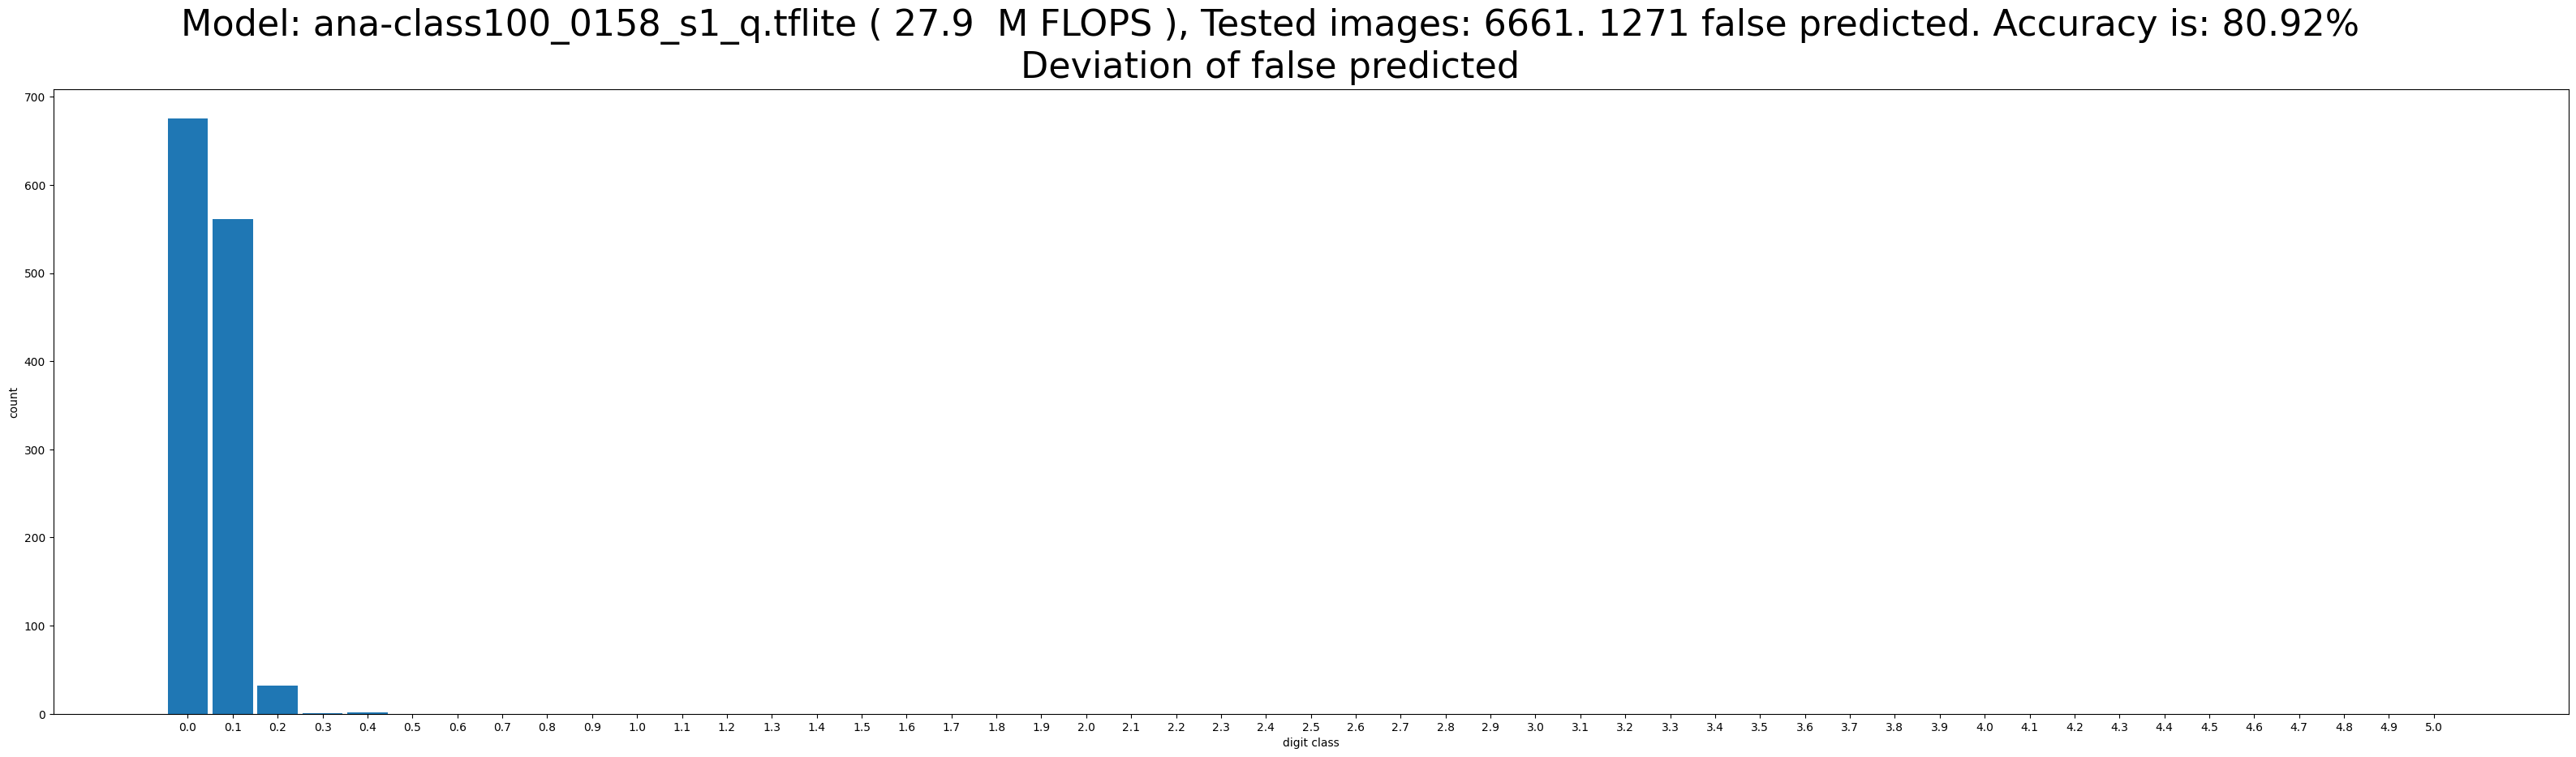

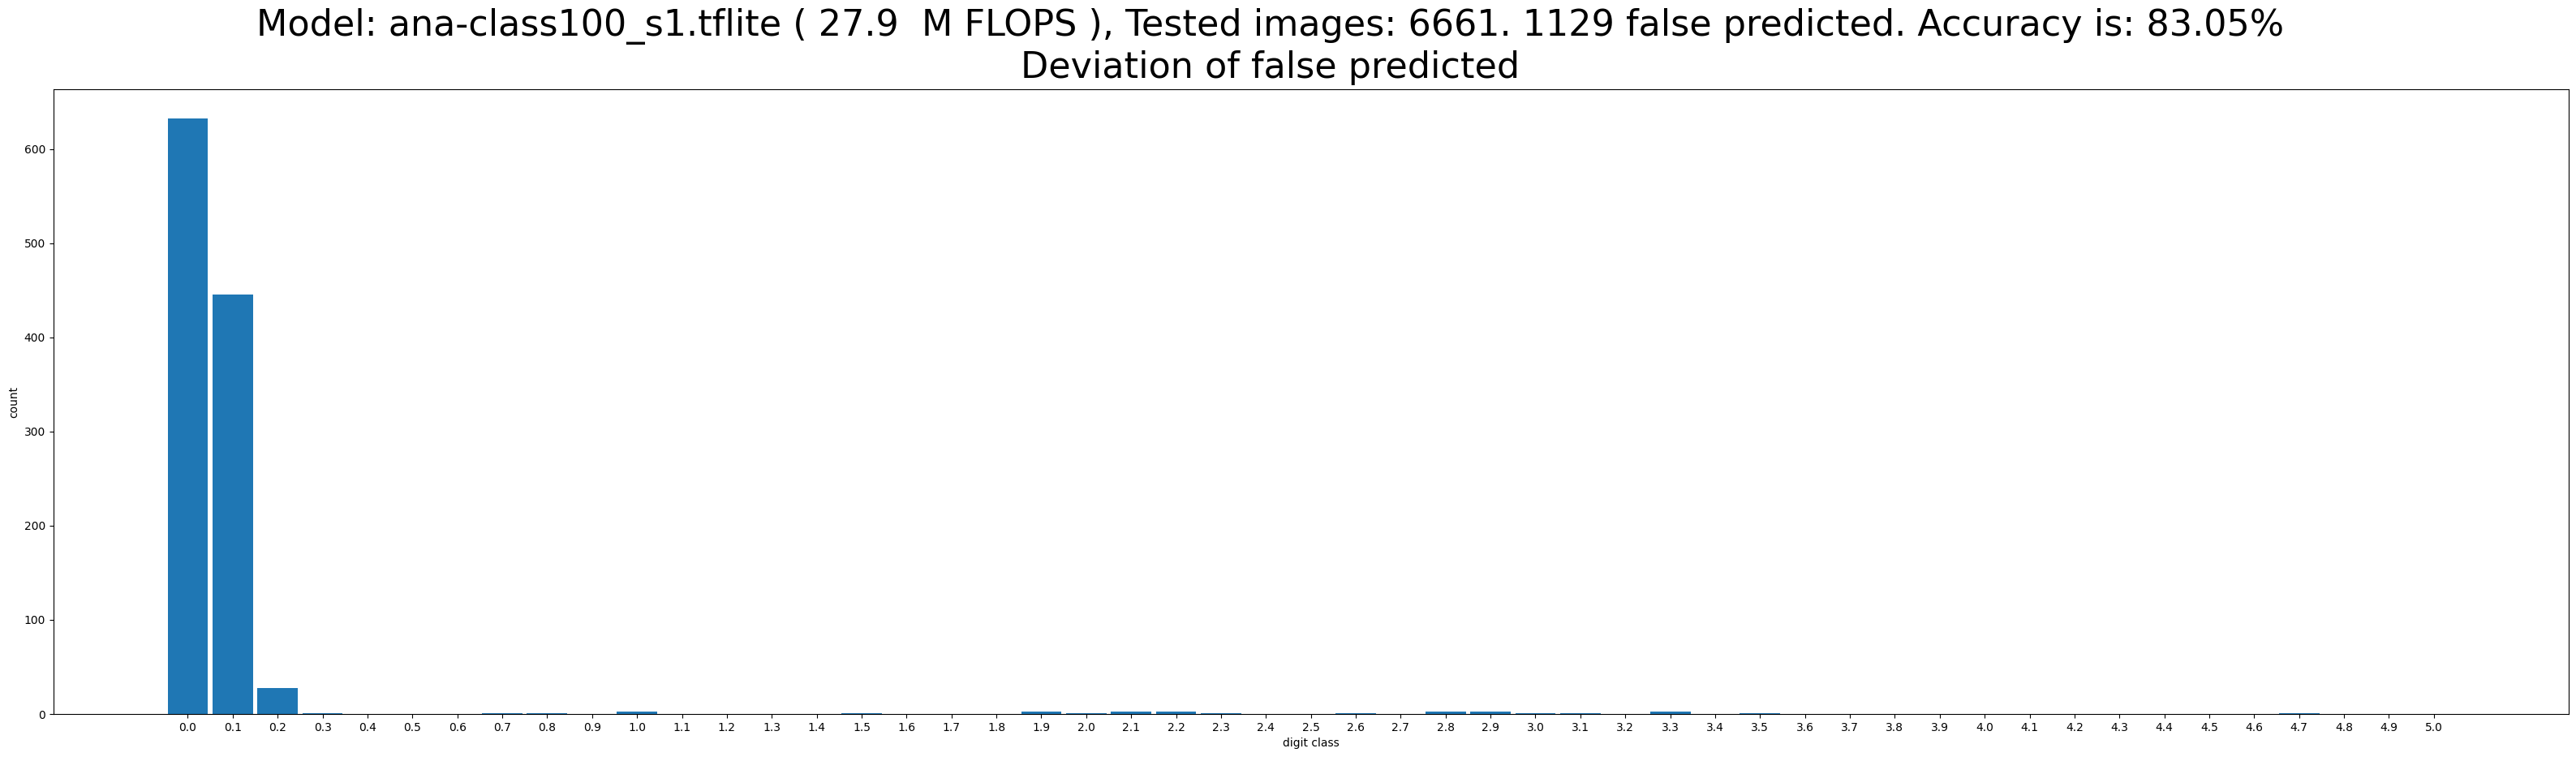

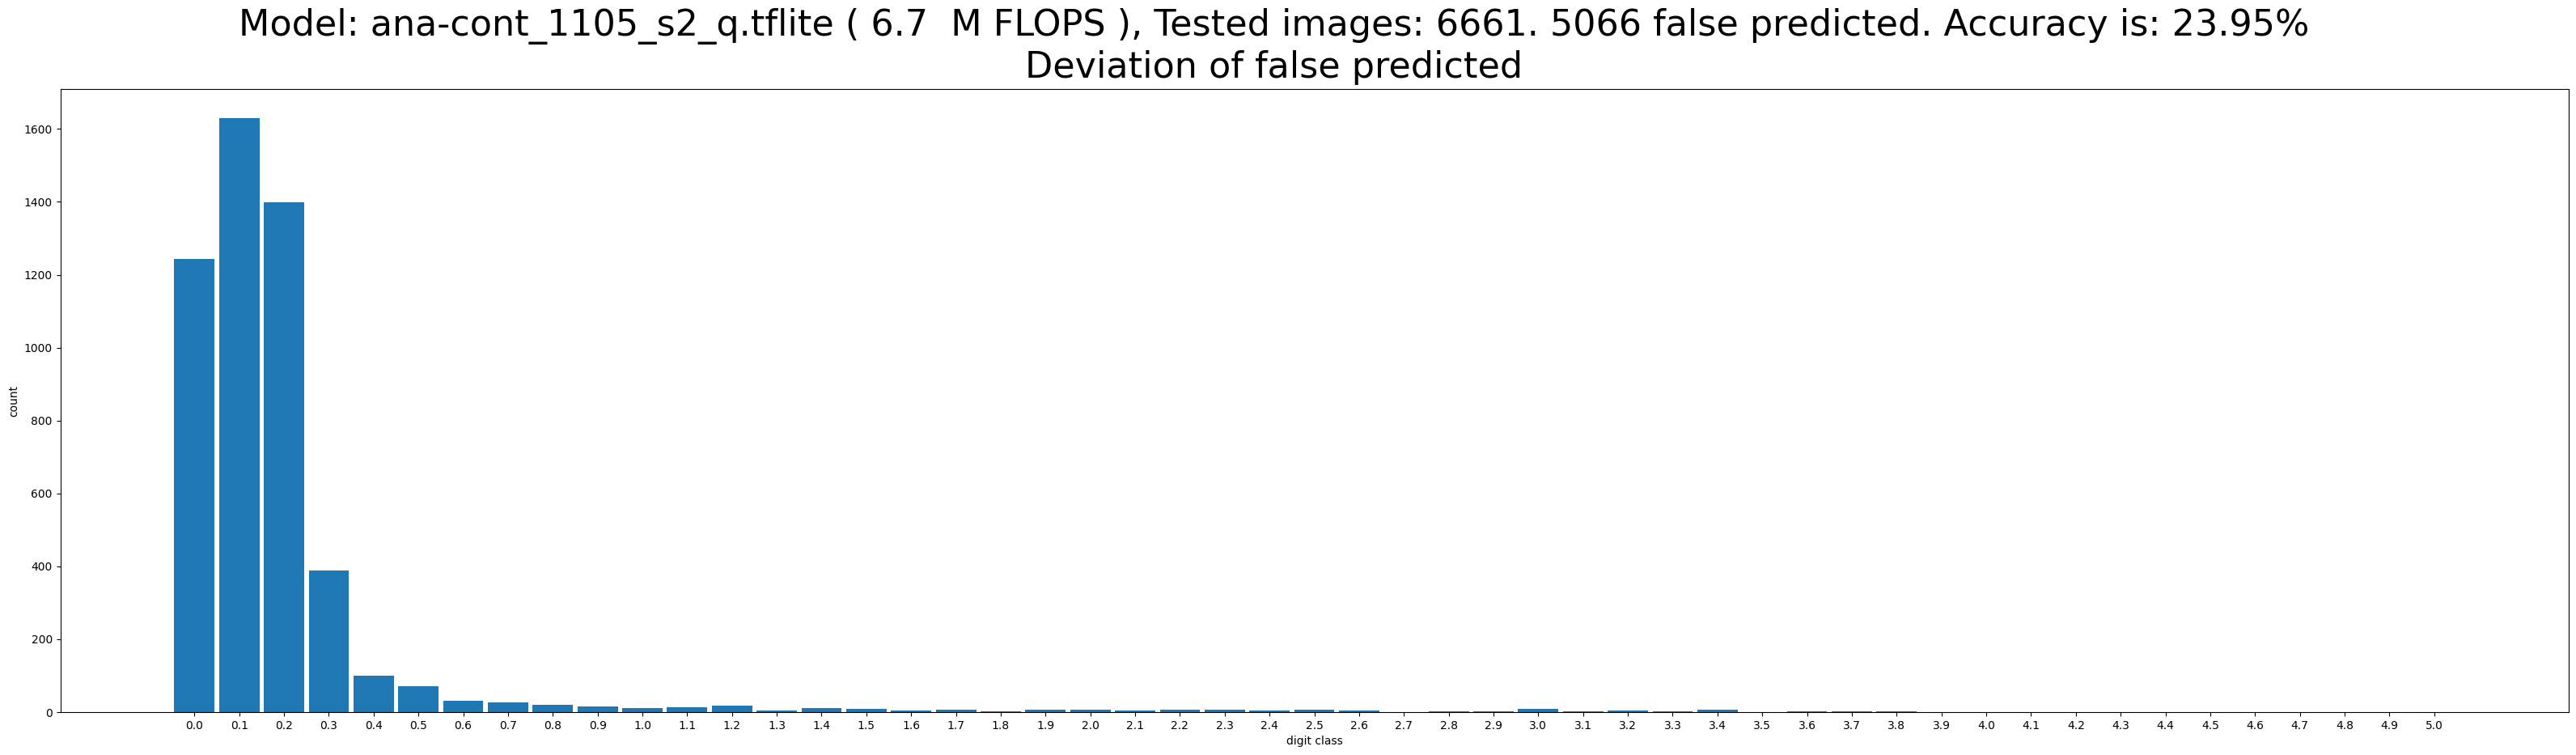

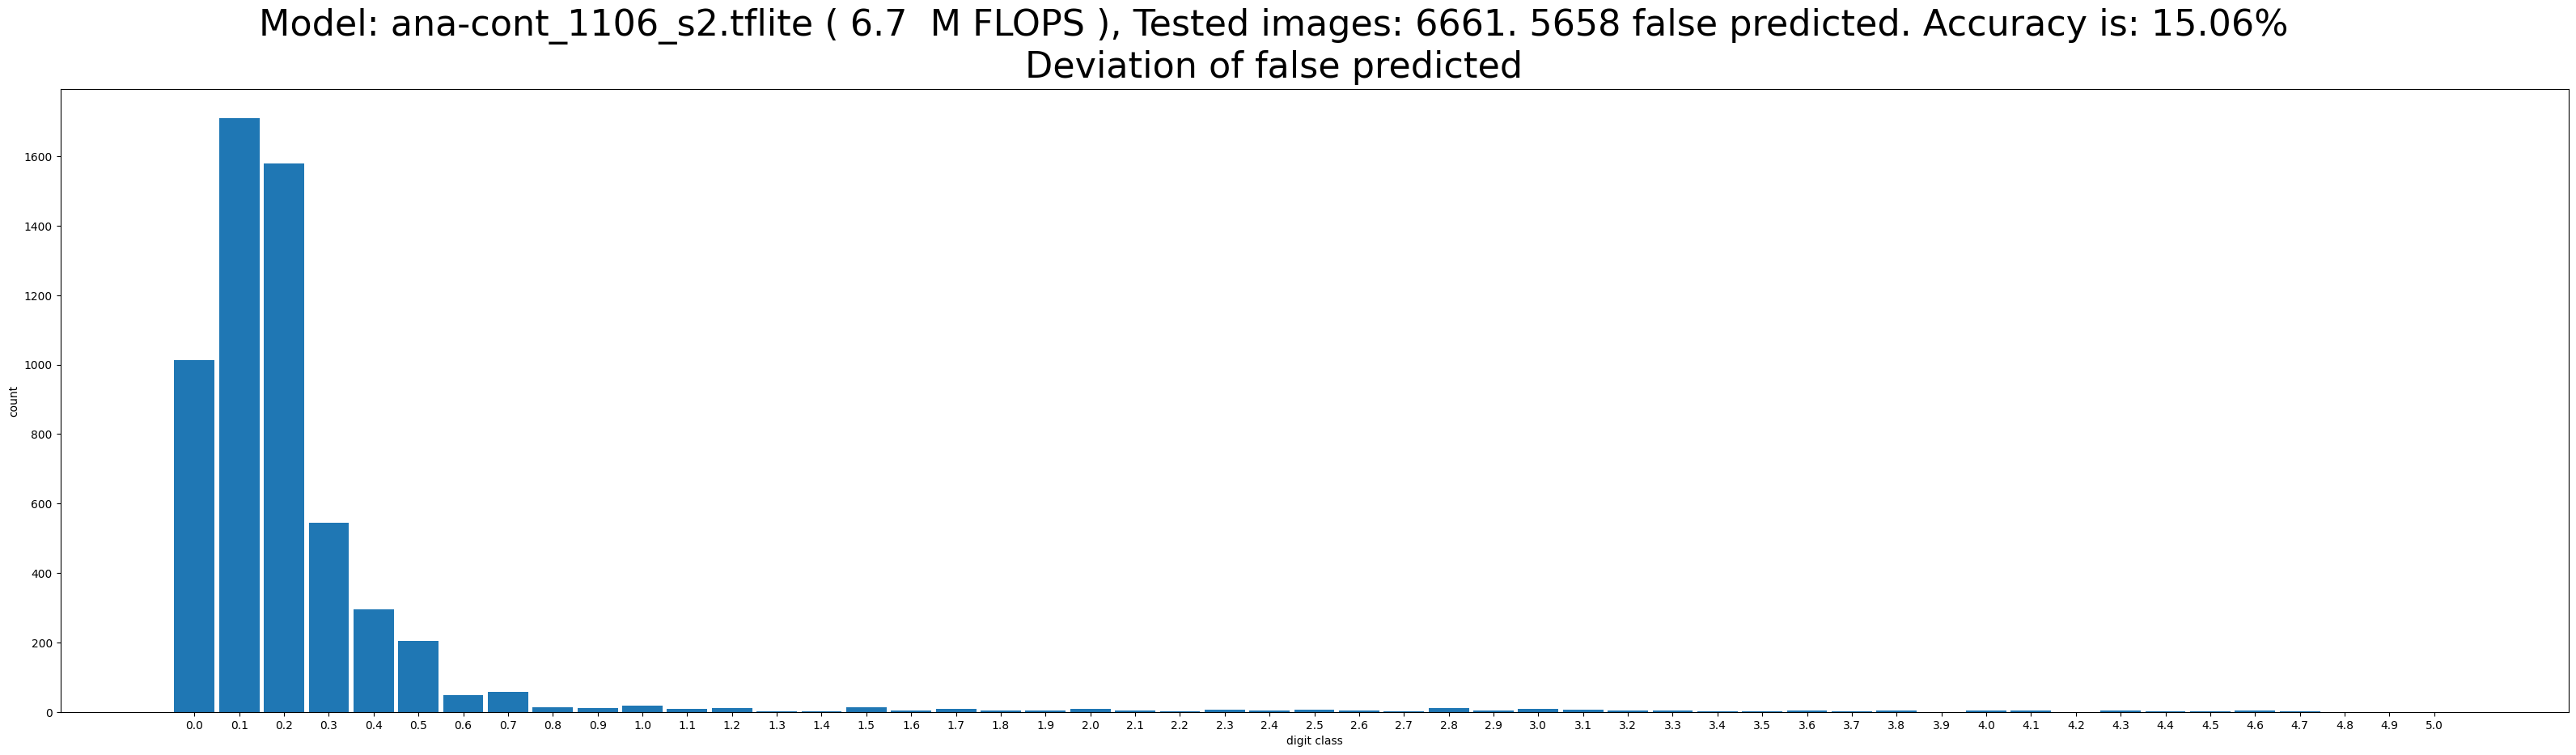

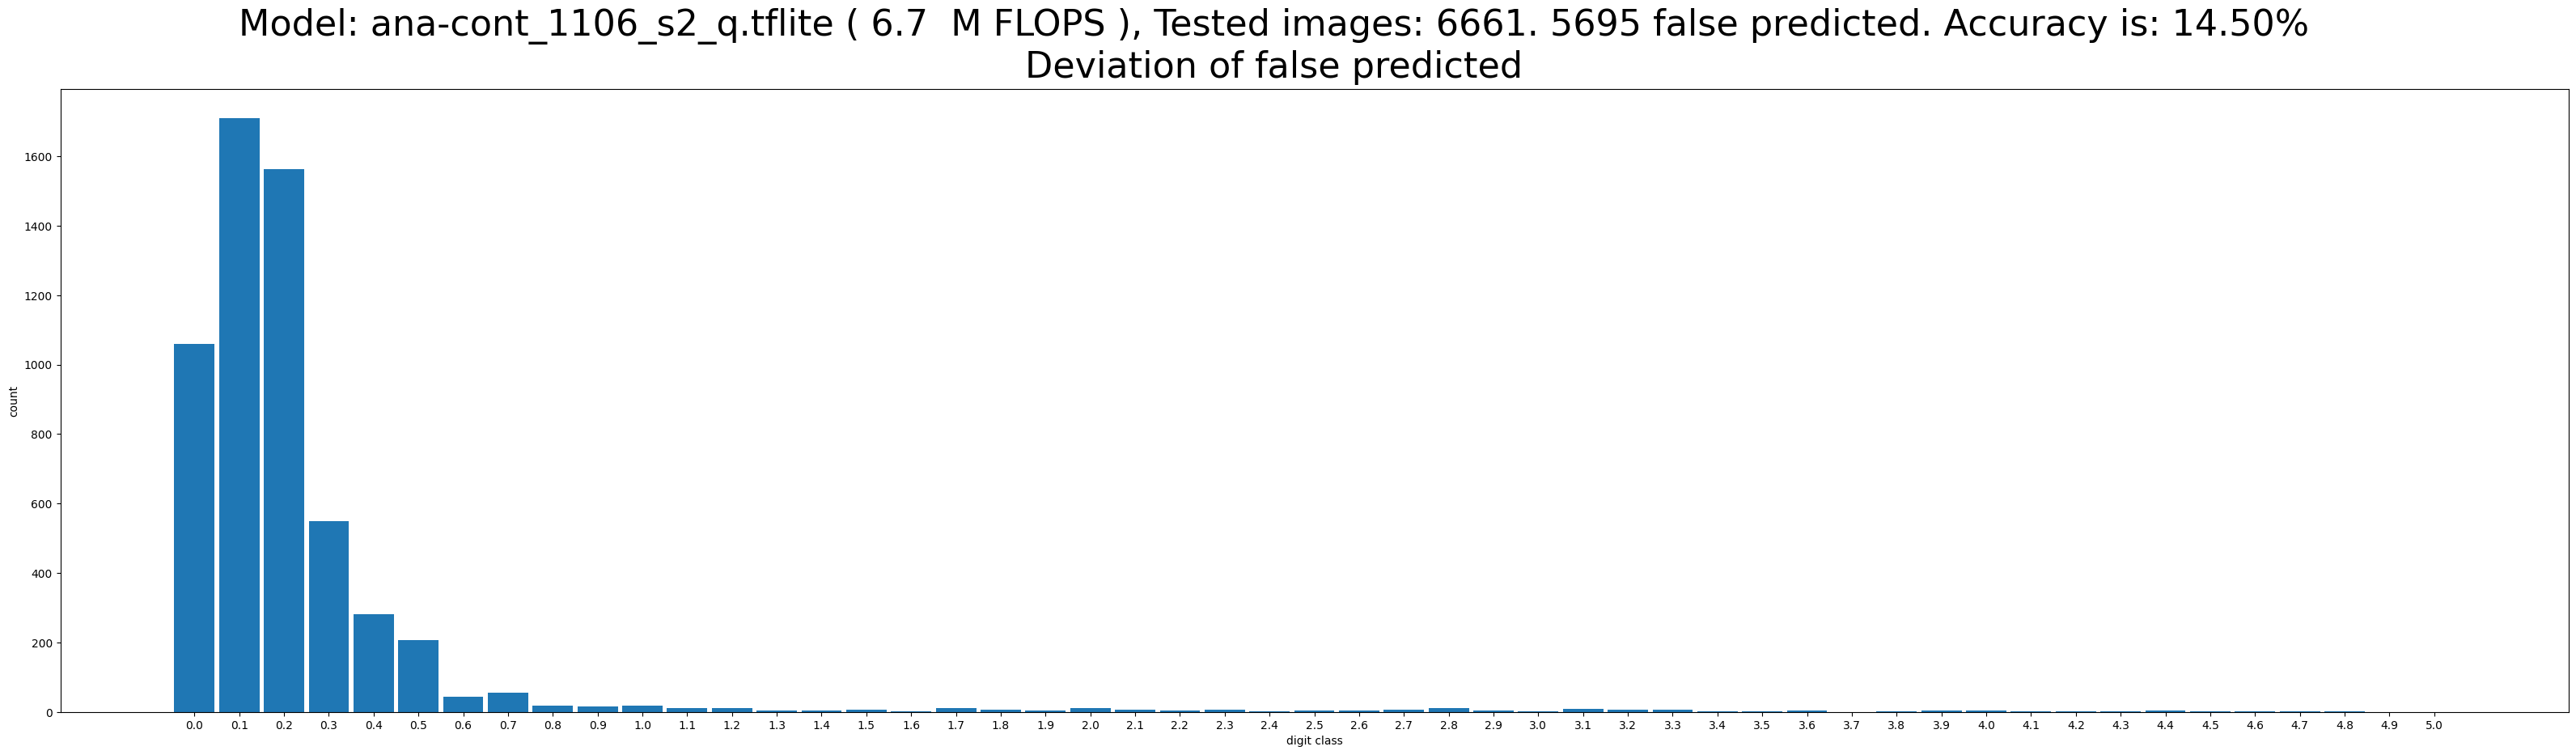

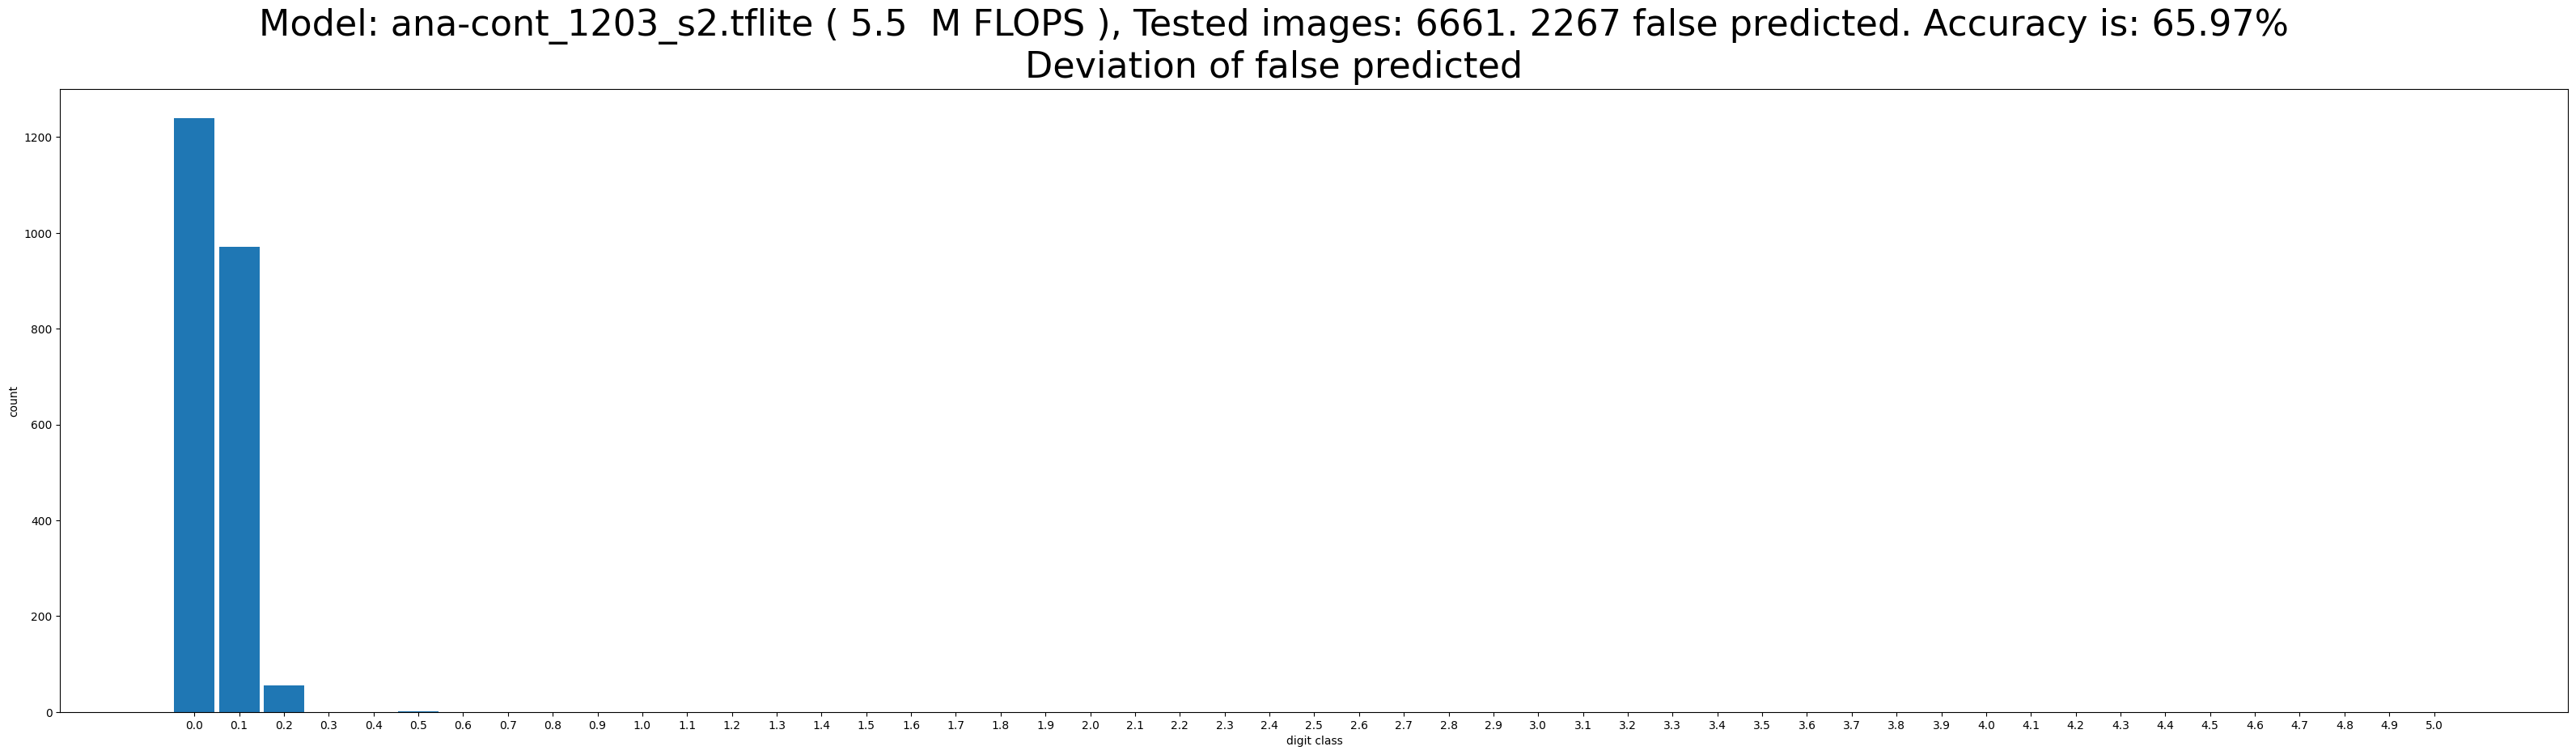

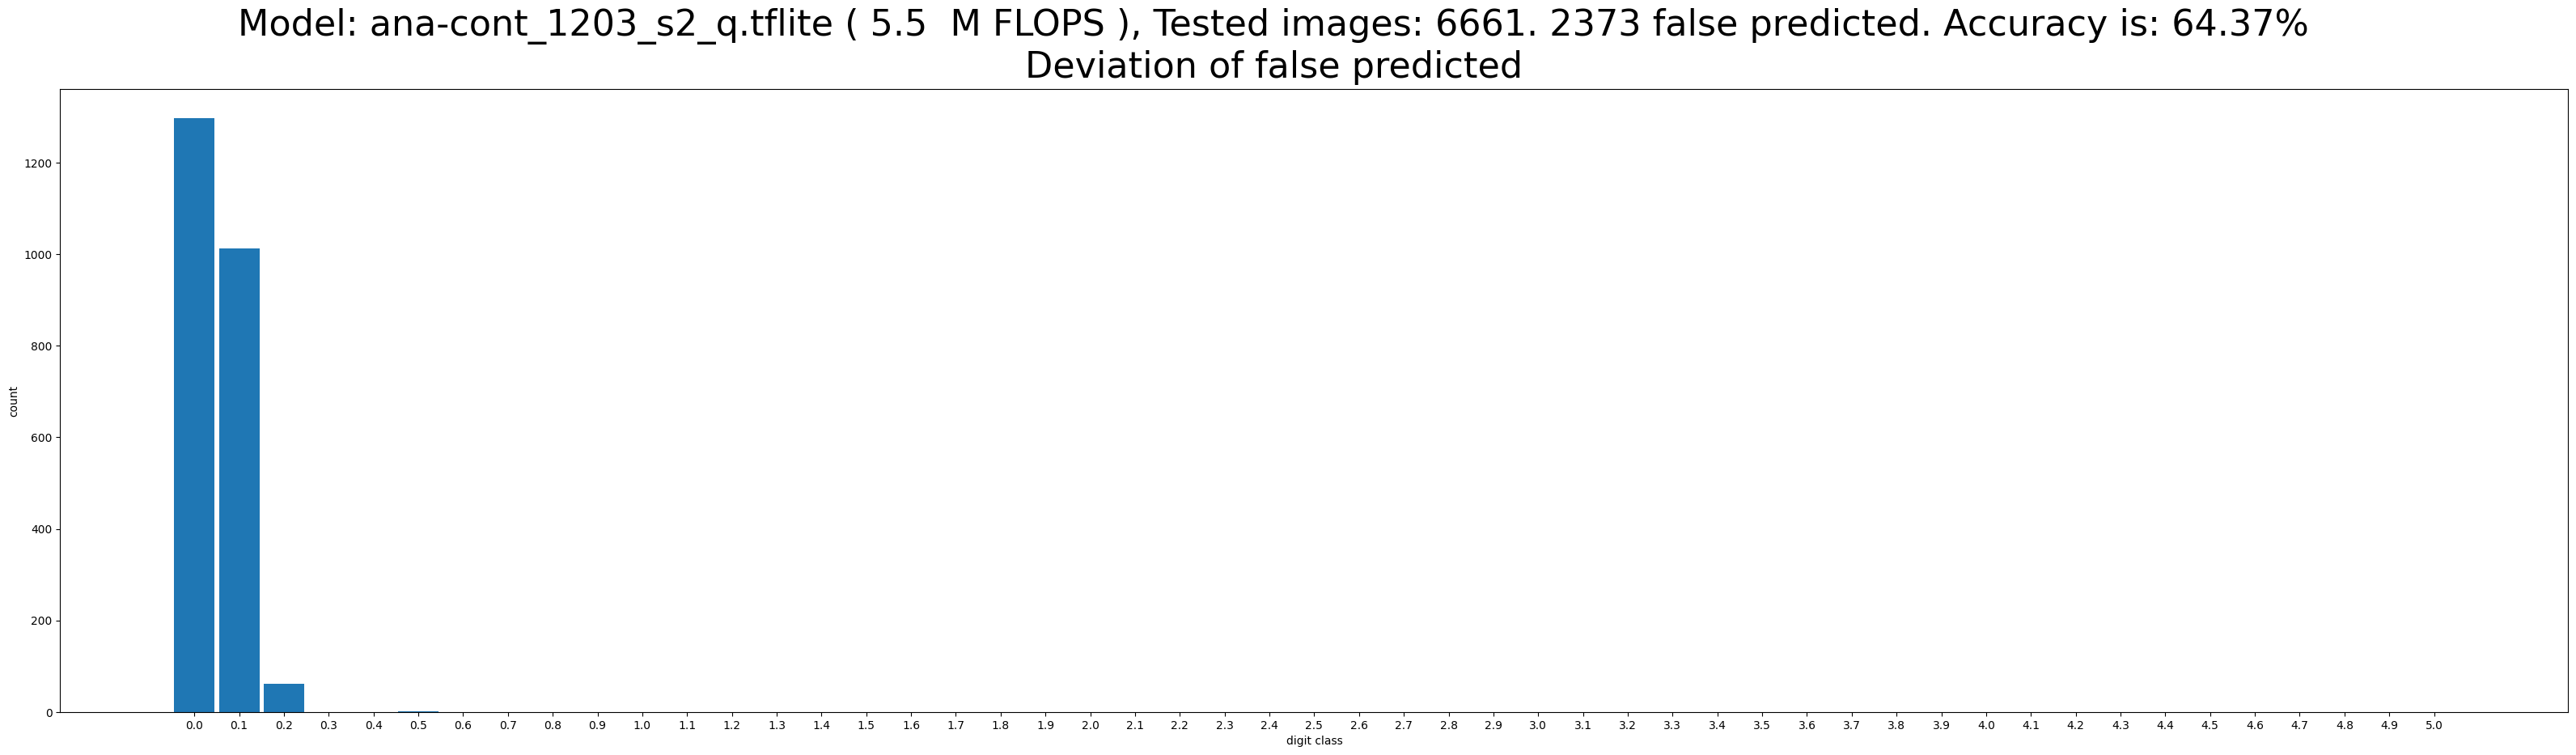

In [69]:
modelfiles = sorted(glob.glob('*.tflite'))
for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, y_data, f_data, title=modelfile, max_delta=0.01)